# Make Figures

Kendra Wyant  
2025-12-27

### Fairness

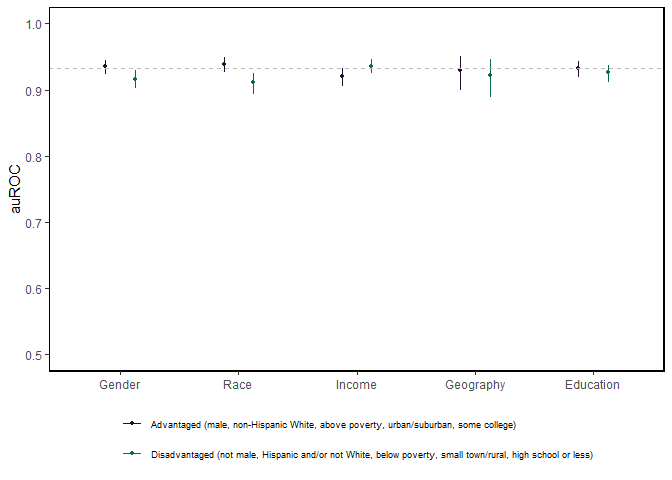

In [ ]:
#| label: fig-1
#| fig-cap: "Posterior probabilities for area under the receiver operating curve (auROC) by demographic subgroup. auROC ranges from .5 (chance performance) to 1 (perfect performance). Subgroups advantaged in access to substance use treatment and outcomes (male, non-Hispanic White, above poverty, urban or surburban geographic location, and some college education) are depicted in dark purple. Subgroups disadvantaged in access to substance use treatment and outcomes (not male, Hispanic and/or not White, below poverty, small town or rural geographic location, and high school education or less) are depicted in green. Overall model performance across groups is depicted as the dashed grey line."
#| message: false
#| code-fold: true

pp_dem |>
  mutate(group = case_match(model,
                               "male" ~ "Gender",
                               "not male" ~ "Gender",
                               "non-Hispanic White" ~ "Race",
                               "Hispanic and/or not white" ~ "Race",
                               "below poverty" ~ "Income",
                               "above poverty" ~ "Income",
                               "urban/suburban" ~ "Geography",
                               "small town/rural" ~ "Geography",
                               "some college" ~ "Education",
                               "high school or less" ~ "Education"),
         fairness = if_else(model %in% c("not male", 
                                         "Hispanic and/or not white",
                                         "below poverty",
                                         "small town/rural",
                                         "high school or less"), 
                            "Disadvantaged (not male, Hispanic and/or not White, below poverty, small town/rural, high school or less)",
                            "Advantaged (male, non-Hispanic White, above poverty, urban/suburban, some college)"),
         fairness = factor(fairness),
         group = factor(group, levels = c("Gender", "Race",
                                                "Income", "Geography", "Education"))) |>  
  ggplot(aes(x = group, y = pp_median, color = fairness)) + 
  geom_point(position = position_dodge(width = 0.5), size = 1) +
  geom_line(position = position_dodge(width = 0.5)) +
  geom_segment(mapping = aes(x = group, y = pp_lower, yend = pp_upper, color = fairness),
               position = position_dodge(width = 0.5)) +
  scale_y_continuous("auROC", limits = c(.50, 1.0)) +
  labs(x = NULL,
       color = NULL) +
  theme_classic() +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 7),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#046B52")) +
  geom_hline(yintercept = subset(pp_all, model == "main")$pp_median, linetype = "dashed",  color = "grey") +
guides(color = guide_legend(nrow = 2, byrow = TRUE))

### Calibration

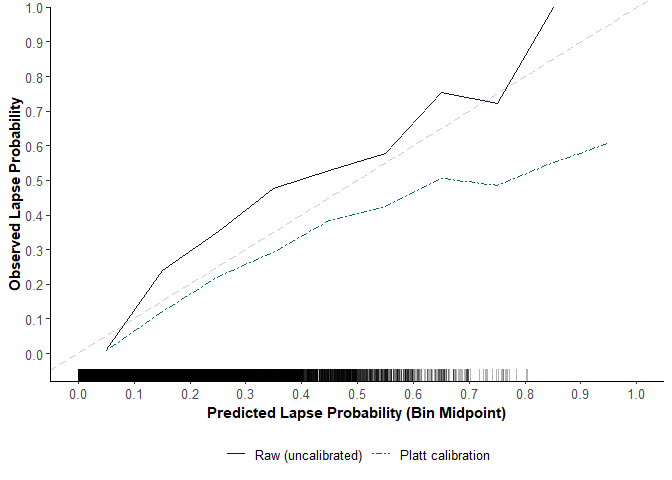

In [ ]:
#| label: fig-2
#| fig-cap: "Calibration plots of raw and calibrated lapse probabilities. Predicted probabilities (x-axis) are binned into deciles. Observed lapse probability (y-axis) represents the proportion of actual lapses observed in each bin. The dashed diagonal represents perfect calibration. Points below the line indicate overestimation and points above the line indicate underestimation. Raw probabilities are depicted as dark purple lines Platt calibrated probabilities are depicted as green dashed lines."

preds_all_raw |> 
  bind_rows(preds_all_logi) |> 
  mutate(prob = factor(prob, levels = c("Raw (uncalibrated)", 
                                        "Platt calibration"))) |> 
  group_by(bins,  prob)  |> 
  summarize(mean_lapse = mean(lapse),
            .groups = "drop") |> 
  mutate(
    bins = as.numeric(bins),
    midpoints = bin_width/2 + bin_width * (bins - 1)
  )  |> 
  ggplot(aes(x = midpoints, y = mean_lapse, group = prob,
             color = prob, linetype = prob)) +
  geom_abline(slope = 1, intercept = 0, linetype = "longdash", color = "gray80") +
  geom_line(linewidth = .7) +
  labs(
    x = "Predicted Lapse Probability (Bin Midpoint)",
    y = "Observed Lapse Probability",
    color = NULL,
    linetype = NULL
  ) +
  geom_rug(data = rug_data, aes(x = rug_x), sides = "b", alpha = 0.3,
           inherit.aes = FALSE) +
  scale_x_continuous(breaks = seq(0, 1, bin_width), limits = c(0, 1)) +
  scale_y_continuous(limits = c(-0.08, 1), breaks = seq(0,1, bin_width),
                     expand = c(0, 0)) +
  coord_cartesian(clip = "off") +
  scale_color_manual(values = c("#240e31", "#046B52")) +
  scale_linetype_manual(values = c("solid", "twodash")) +
  theme_classic(base_size = 11) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 11),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 10),
    axis.title = element_text(face = "bold")
  )

### Feature Importance

top 30

In [ ]:
#| code-fold: true

shap_levels <- shaps |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  arrange(desc(mean_value)) |> 
  slice_head(n = 30) |> 
  arrange(mean_value) |> 
  pull(variable_grp)

n_obs <- max(shaps$id_obs)

shaps_day_max <- shaps |>
  group_by(id_obs) |>
  slice_max(value) |> 
  group_by(variable_grp) |> 
  summarise(n = n(),
            prop = n/n_obs) |> 
  ungroup() 


global_panel <- shaps |>
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  filter(variable_grp %in% shap_levels) |> 
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  ggplot(mapping = aes(x = variable_grp, y = mean_value)) +
  geom_bar(fill = "#240e31", 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  theme_classic() +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()


local_panel <- shaps_day_max |> 
  filter(variable_grp %in% shap_levels) |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |>
  ggplot(mapping = aes(x = variable_grp, y = prop)) +
  geom_bar(fill = "#046B52", 
           stat = "identity", position = "dodge") +
  labs(y = "Proportion of days as top feature",
       x = NULL,
       fill = NULL) +
  theme_classic() +
  theme(axis.text=element_text(size=9.5),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()

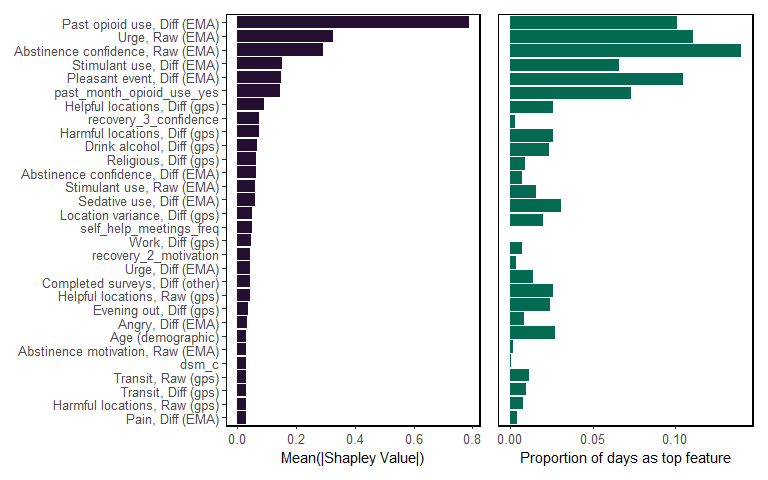

In [ ]:
#| label: fig-3
#| fig-width: 8

global_panel + local_panel

Supplemental figure with all feature groups

In [ ]:
#| code-fold: true

shap_levels_all <- shaps |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(mean_value) |> 
  pull(variable_grp)


global_panel_all <- shaps |>
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  mutate(variable_grp = factor(variable_grp, levels = shap_levels_all)) |> 
  ggplot(mapping = aes(x = variable_grp, y = mean_value)) +
  geom_bar(fill = "#240e31", 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  theme_classic() +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()


local_panel_all <- shaps_day_max |> 
  right_join(shaps |> ungroup() |> select(variable_grp) |> distinct(), 
             by = "variable_grp") |> 
  mutate(prop = if_else(is.na(prop), 0, prop)) |> 
  mutate(variable_grp = factor(variable_grp, levels = shap_levels_all)) |>
  ggplot(mapping = aes(x = variable_grp, y = prop)) +
  geom_bar(fill = "#046B52", 
           stat = "identity", position = "dodge") +
  labs(y = "Proportion of days as top feature",
       x = NULL,
       fill = NULL) +
  theme_classic() +
  theme(axis.text=element_text(size=9.5),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()

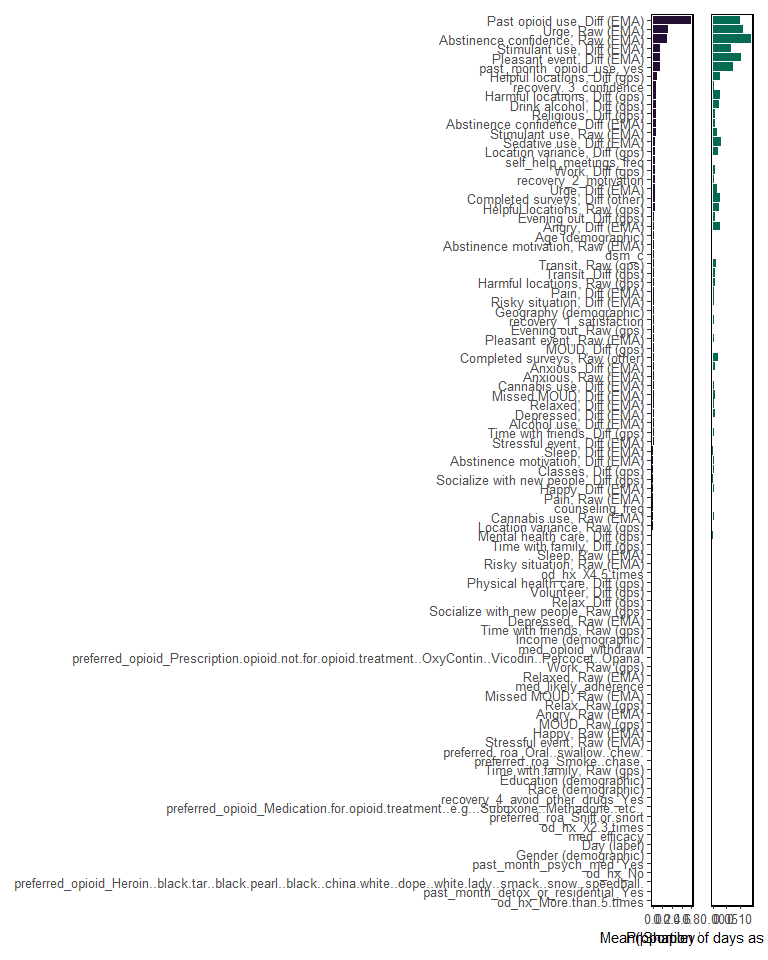

Individual Shapley plots (about 90 categories total)

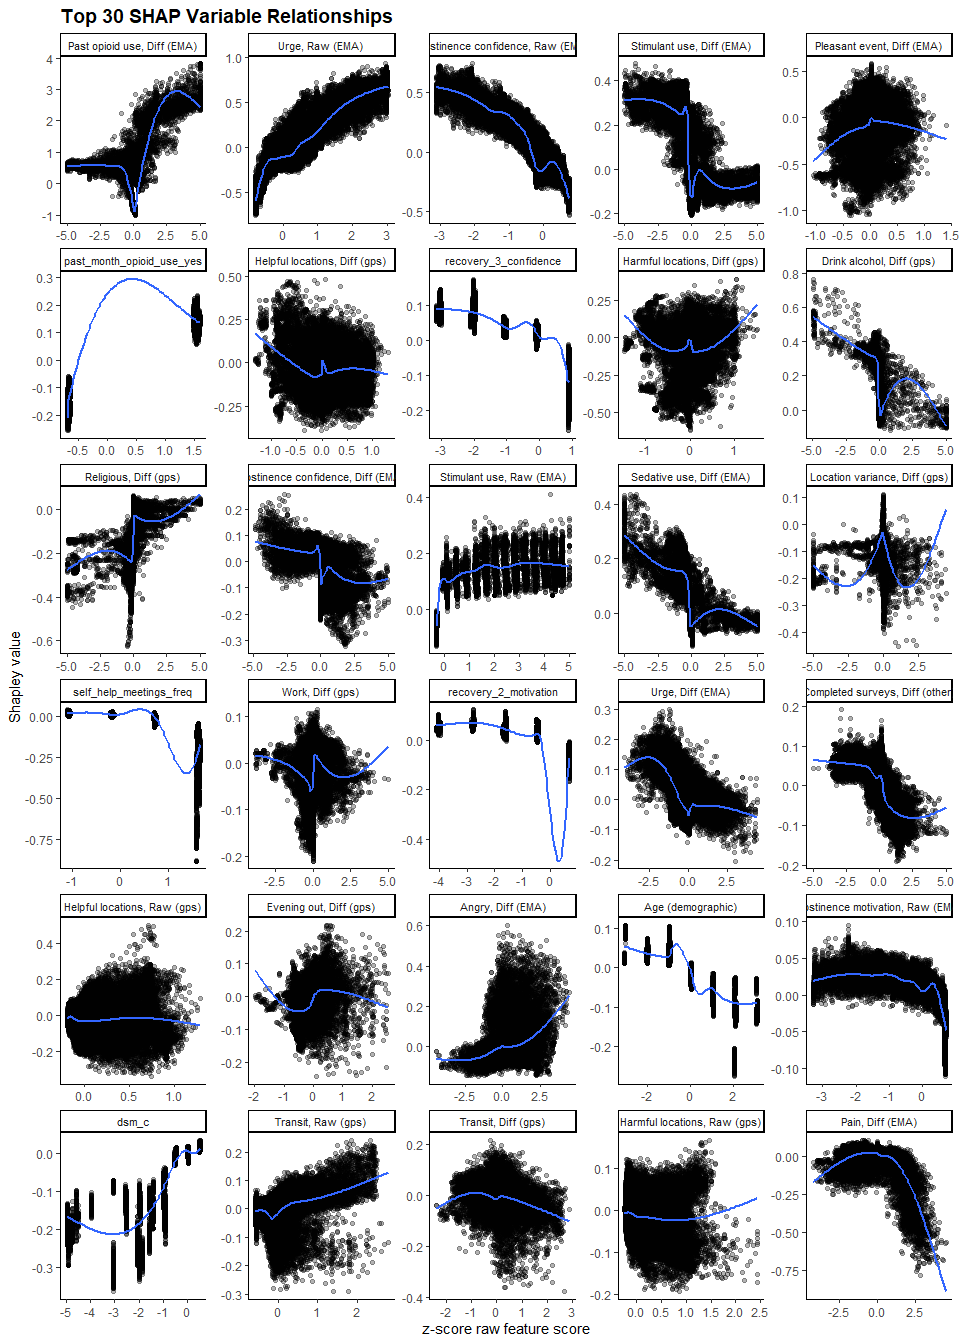

In [ ]:
#| label: fig-4
#| fig-cap: "Feature importance partial dependence plots."
#| message: false
#| fig-width: 10
#| fig-height: 14
#| code-fold: true

shap_levels <- shaps |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(desc(mean_value)) |> 
  slice_head(n = 30) |> 
  pull(variable_grp)

shaps|>
  filter(variable_grp %in% shap_levels) |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |>
  ggplot(aes(x = rfvalue, y = value)) +
  geom_point(alpha = .3) +
  geom_smooth(method = "gam", formula = y ~ s(x, k = 10, bs = "cs"), se = FALSE) +
  facet_wrap(~ variable_grp, scales = "free", ncol = 5) +
  labs(
    title = "Top 30 SHAP Variable Relationships",
    x = "z-score raw feature score",
    y = "Shapley value"
  ) +
  theme_classic() +
  theme(
    strip.text = element_text(size = 8),
    plot.title = element_text(size = 14, face = "bold")
  )

Individual Shapley plots by raw and diff

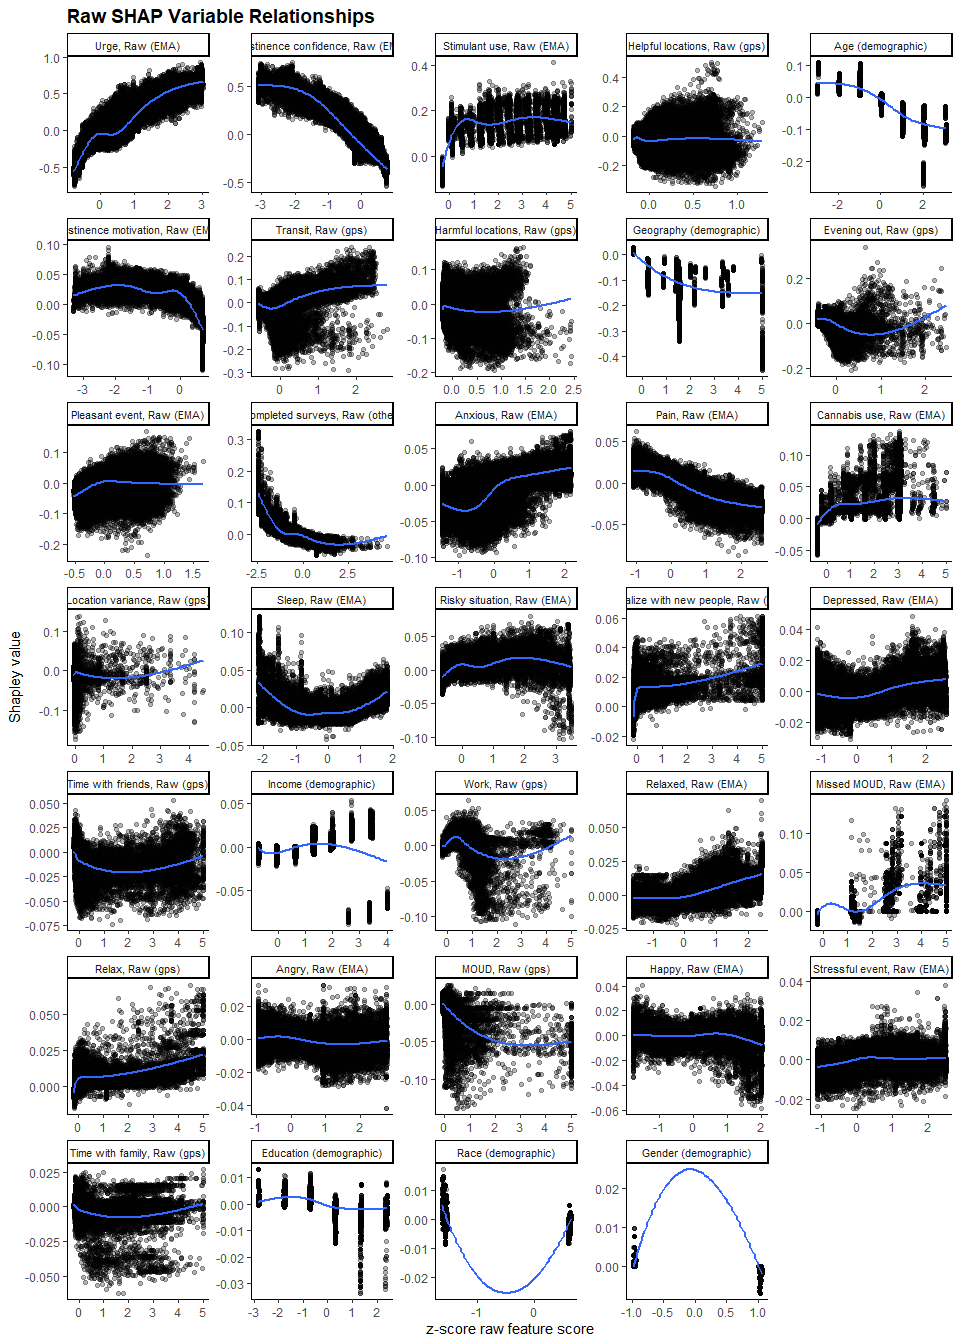

In [ ]:
#| label: fig-5
#| fig-cap: "Raw feature importance partial dependence plots."
#| message: false
#| fig-width: 10
#| fig-height: 14
#| code-fold: true

shap_levels <- shaps |> 
  filter(str_detect(variable_grp, "Raw") | str_detect(variable_grp, "demographic")) |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(desc(mean_value)) |> 
  pull(variable_grp)

shaps|>
  filter(variable_grp %in% shap_levels) |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |>
  ggplot(aes(x = rfvalue, y = value)) +
  geom_point(alpha = .3) +
  geom_smooth(method = "gam", formula = y ~ s(x, k = 5, bs = "cs"), se = FALSE) +
  facet_wrap(~ variable_grp, scales = "free", ncol = 5) +
  labs(
    title = "Raw SHAP Variable Relationships",
    x = "z-score raw feature score",
    y = "Shapley value"
  ) +
  theme_classic() +
  theme(
    strip.text = element_text(size = 8),
    plot.title = element_text(size = 14, face = "bold")
  )

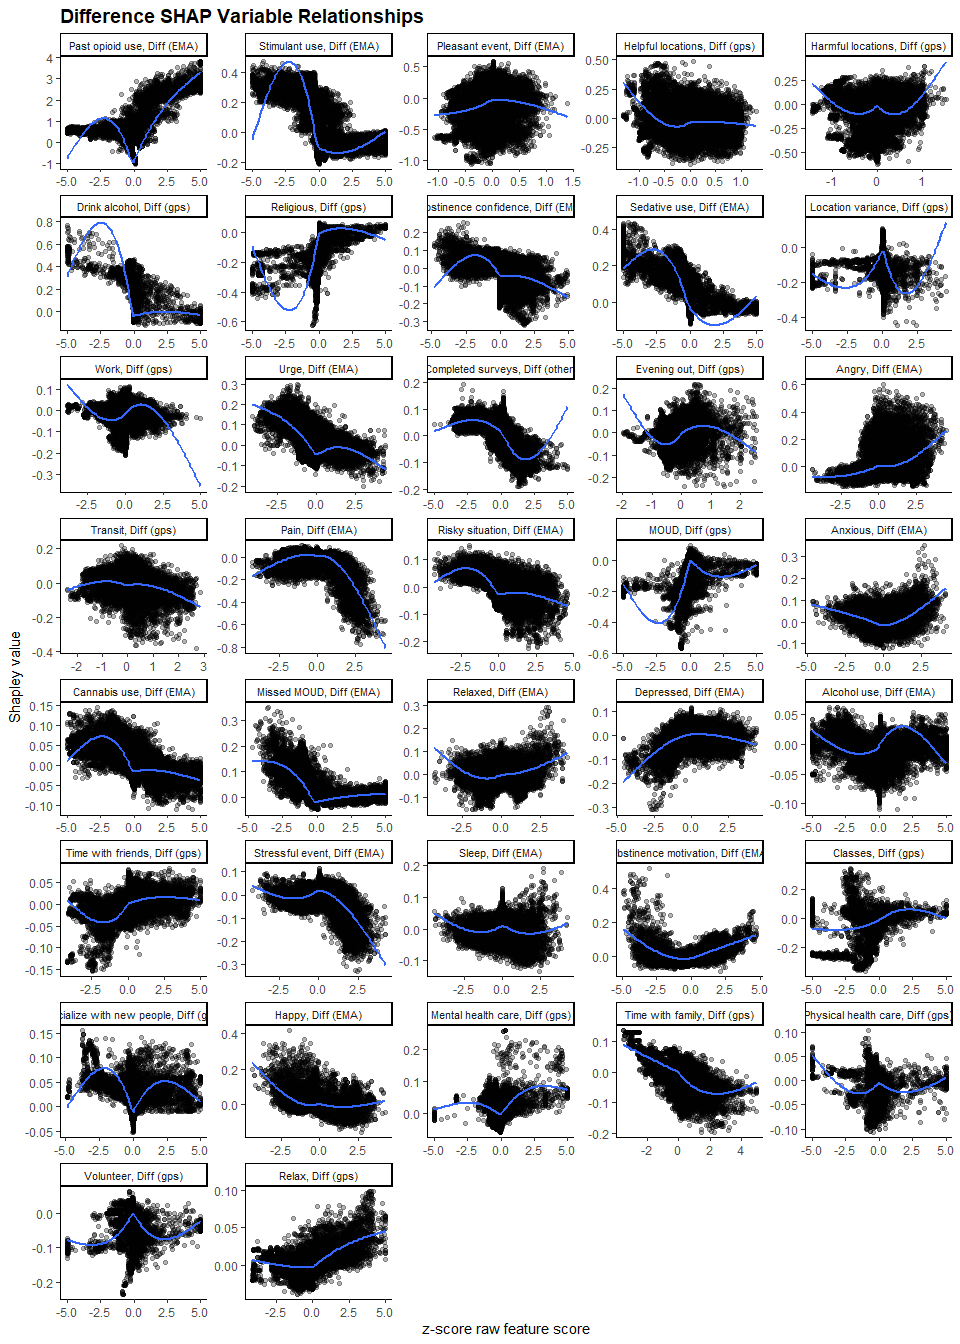

In [ ]:
#| label: fig-6
#| fig-cap: "Difference feature importance partial dependence plots."
#| message: false
#| fig-width: 10
#| fig-height: 14
#| code-fold: true

shap_levels <- shaps |> 
  filter(str_detect(variable_grp, "Diff")) |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(desc(mean_value)) |> 
  pull(variable_grp)

shaps|>
  filter(variable_grp %in% shap_levels) |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |>
  ggplot(aes(x = rfvalue, y = value)) +
  geom_point(alpha = .3) +
  geom_smooth(method = "gam", formula = y ~ s(x, k = 5, bs = "cs"), se = FALSE) +
  facet_wrap(~ variable_grp, scales = "free", ncol = 5) +
  labs(
    title = "Difference SHAP Variable Relationships",
    x = "z-score raw feature score",
    y = "Shapley value"
  ) +
  theme_classic() +
  theme(
    strip.text = element_text(size = 8),
    plot.title = element_text(size = 14, face = "bold")
  )